In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, fixed, FloatSlider, IntSlider

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def get_dados(indice='portfolio'):
    if indice=='portfolio':
        df = pd.read_csv('dados/retorno_portfolio.csv', parse_dates=['Date'])
        df.fillna(0, inplace=True)
    if indice=='ACWI':    
        df = pd.read_csv('dados/retorno_portfolio.csv', parse_dates=['Date'])
        df.fillna(0, inplace=True)
        df['retorno'] = df['ACWI']
    else:
        url = f'https://query1.finance.yahoo.com/v7/finance/download/{indice}?period1=852076800&period2=1634743473&interval=1d&events=history&includeAdjustedClose=true'
        df = pd.read_csv(url)
        df['Date'] = pd.to_datetime(df['Date'])
        df['retorno'] = df['Close'].pct_change()
        
    df['year_week'] = df['Date'].dt.strftime('%Y-%U')
    df['retorno acumulado'] = df['retorno'] + 1
    df['retorno acumulado'] = df['retorno acumulado'].cumprod()
    
    df_gsrai = pd.read_csv('dados/GSRAII.csv', parse_dates=['Date']).sort_values('Date')

    df = df.merge(df_gsrai, on='Date')
    return df[['Date', 'retorno acumulado', 'GSRAII Index', 'year_week']].dropna()

### Indices:
- ^GSPC = *SP500*
- ^BVSP = *Bovespa*
- ACWI
- portfolio

In [4]:
# Trocar codigo do indice
indice='^BVSP'
df = get_dados(indice=indice)
df

,Date,retorno acumulado,GSRAII Index,year_week
1,1997-01-03,1.006081,0.13,1997-00
2,1997-01-06,1.029329,0.22,1997-01
3,1997-01-07,1.029329,0.21,1997-01
4,1997-01-08,1.067788,0.22,1997-01
5,1997-01-09,1.071699,0.18,1997-01
...,...,...,...,...
6180,2021-08-19,16.844943,-0.11,2021-33
6181,2021-08-20,16.972612,-0.09,2021-33
6182,2021-08-23,16.889081,-0.02,2021-34
6183,2021-08-24,17.282870,0.08,2021-34


In [5]:
#%% Semanal
df_gp = df.groupby('year_week').agg('last')

In [6]:
for pct in range(1,6):
    df_gp[f'pct_sem_0-{pct}'] = (df_gp['retorno acumulado']/df_gp['retorno acumulado'].shift(pct).values -1) * 100

In [7]:
def classe_gsrai(df, limit=0, media_movel=3):
    
    df=df.copy()
    df['mean'] = df['GSRAII Index'].rolling(media_movel).mean()
    up_down = df['mean']

    df['gsrai_gt_up'] = np.where((df['GSRAII Index'] > up_down) & (df['GSRAII Index'] >= limit), 1, 0)
    df['gsrai_gt_down'] = np.where((df['GSRAII Index'] < up_down) & (df['GSRAII Index'] >= limit), 1, 0)
    df['gsrai_lt_up'] = np.where((df['GSRAII Index'] > up_down) & (df['GSRAII Index'] < limit), 1, 0)
    df['gsrai_lt_down'] = np.where((df['GSRAII Index'] < up_down) & (df['GSRAII Index'] < limit), 1, 0)

    regras = ['gsrai_gt_up', 'gsrai_gt_down', 'gsrai_lt_up', 'gsrai_lt_down']
    df['classe'] = np.nan
    for col in regras:
        df.loc[df[col]==1, 'classe'] = col
    return df.dropna()

In [8]:
df_gp =  classe_gsrai(df=df_gp, limit=0, media_movel=3)

In [9]:
pct =  'pct_sem_0-3'
regras = ['gsrai_gt_up', 'gsrai_gt_down', 'gsrai_lt_up', 'gsrai_lt_down']

In [11]:
lista = []
for col in df_gp['classe'].unique():
    desc = df_gp[df_gp[col]==1][[pct]].describe().rename(columns={pct: col})
    lista.append(desc)
pd.concat(lista, axis=1)

,gsrai_gt_down,gsrai_gt_up,gsrai_lt_down,gsrai_lt_up
count,260.000000,374.000000,342.000000,309.000000
mean,1.281644,2.807282,-3.068645,2.573378
std,5.348854,5.031657,7.901230,7.741446
min,-14.465524,-11.841955,-35.617056,-28.324439
25%,-2.230008,-0.285660,-6.474383,-1.296088
50%,1.521137,3.133290,-2.870877,2.813939
75%,5.050835,5.913067,1.471706,6.378335
max,14.791337,24.925063,21.058606,25.992768


In [12]:
@interact(df=fixed(df_gp), 
          pct=['pct_sem_0-1','pct_sem_0-2', 'pct_sem_0-3', 'pct_sem_0-4', 'pct_sem_0-5'],
          limit=FloatSlider(min=-1, max=1, step=0.05, value=0),
          media_movel=IntSlider(min=2, max=6, step=1, value=3)
         )
def hist_classes(df, pct, limit=0, media_movel=3):
    df = classe_gsrai(df=df, limit=limit, media_movel=media_movel)
    fig = px.histogram(df, x=pct, color="classe", marginal="box", nbins=100, 
#                        range_y=[0,50],
                       range_x=[df[pct].min()-1,df[pct].max()+1],
                       title=f'Distribuição {indice} {pct} ',
                      )
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.65)
    fig.add_vline(x=0,line_dash="dash")
    
    for i, classe in enumerate(df['classe'].unique()):
        fig.add_annotation(text=f'Total {classe}: {len(df[df["classe"]==classe])} ',
                           showarrow=False, yshift=70-(i*19), xshift=450)
        fig.add_annotation(text=f'σ {classe}: {df[df["classe"]==classe][pct].std():.2f} ',
                           showarrow=False, yshift=200-(i*19), xshift=450)
    
    return fig

    
hist_classes(df_gp, pct, limit=-1, media_movel=3);

interactive(children=(Dropdown(description='pct', options=('pct_sem_0-1', 'pct_sem_0-2', 'pct_sem_0-3', 'pct_s…

In [13]:
cut = df_gp[pct].quantile(0.05)
df_gp[(df_gp['pct_sem_0-3']<=cut)].sum()

retorno acumulado                                           289.802746
GSRAII Index                                                    -69.86
pct_sem_0-1                                                -388.174745
pct_sem_0-2                                                 -747.01848
pct_sem_0-3                                               -1067.847647
pct_sem_0-4                                               -1105.903804
pct_sem_0-5                                               -1144.518671
mean                                                        -58.483333
gsrai_gt_up                                                          1
gsrai_gt_down                                                        6
gsrai_lt_up                                                         15
gsrai_lt_down                                                       43
classe               gsrai_lt_downgsrai_lt_downgsrai_lt_downgsrai_l...
dtype: object

In [14]:
df_gp[(df_gp['pct_sem_0-3']>cut) & (df_gp['gsrai_lt_down']==1)][pct].describe()

count    299.000000
mean      -1.001708
std        5.365030
min       -9.986539
25%       -5.012577
50%       -2.086641
75%        2.069678
max       21.058606
Name: pct_sem_0-3, dtype: float64

<AxesSubplot:>

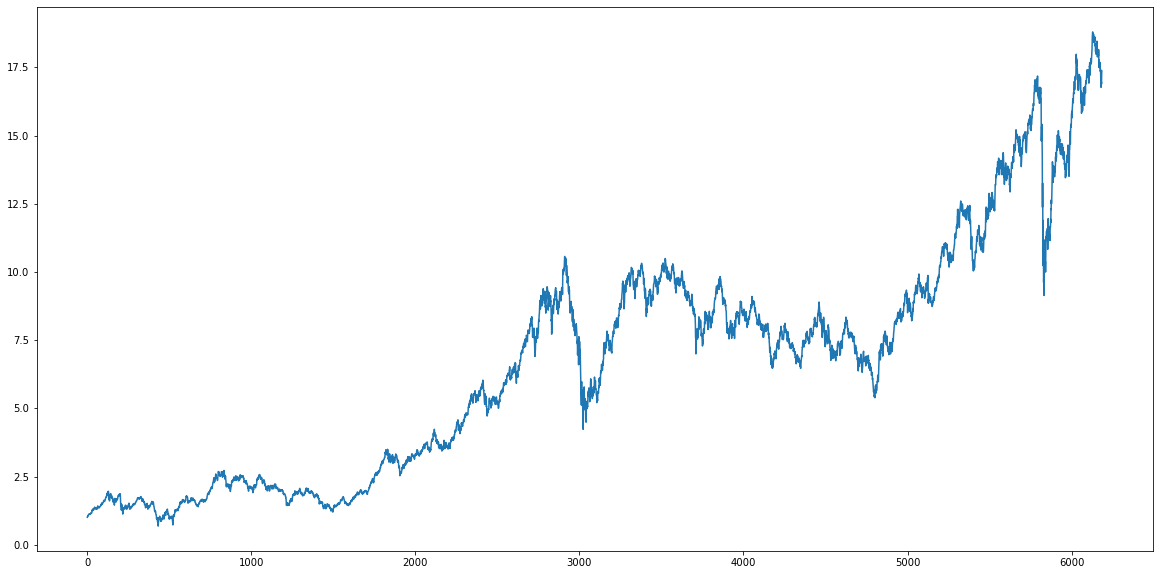

In [15]:
df['retorno acumulado'].plot(x = 'Date', figsize=(20,10))